![](https://i.gyazo.com/9f0eb0c17a420ec39d6c86668b06e827.png)

In [23]:
# IMPORTS

import json
import math
import os
import pickle
import random
import string
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
from tqdm import tqdm

unk = '<UNK>'

In [24]:
class RNN(nn.Module):
    def __init__(self, input_dim, h):
        super(RNN, self).__init__()
        self.h = h
        self.numOfLayer = 1
        self.rnn = nn.RNN(input_dim, h, self.numOfLayer, nonlinearity='tanh')
        self.W = nn.Linear(h, 5)
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.NLLLoss()

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, inputs):
        # Obtain hidden layer representation
        _, hidden = self.rnn(inputs)

        # Obtain output layer representations
        output = self.W(hidden)

        # Sum over output
        output = torch.sum(output, dim=0)

        # Obtain probability distribution
        predicted_vector = self.softmax(output)

        return predicted_vector

In [25]:
def load_data(data):
    with open(data) as data_f:
        data_json = json.load(data_f)

    return [(elt["text"].split(), int(elt["stars"] - 1)) for elt in data_json]

In [26]:
from dataclasses import dataclass
from typing import List

@dataclass
class Args:
    """
    hidden_dim (int): hidden dimension
    epochs (int): number of epochs to train
    train_data (str): path to training data
    val_data (str): path to validation data
    test_data (str): path to test data
    """
    hidden_dims: List[int]
    epochs: int
    train_data: str
    val_data: str
    test_data: str = "to fill"
    
args = Args(
    hidden_dims=[32, 64, 128, 256, 512, 1024],
    epochs=10,
    train_data="training.json",
    val_data="validation.json",
    test_data="test.json",
)

In [27]:
# fix random seeds
random.seed(42)
torch.manual_seed(42)

In [28]:
# see if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
train_data, valid_data = load_data(args.train_data), load_data(args.val_data)
word_embedding = pickle.load(open('word_embedding.pkl', 'rb'))

In [51]:
# Stats about the data
print("Training Data Size:", len(train_data))
print("Validation Data Size:", len(valid_data))

# Find class splits in train and validation data
train_class_counts = [0] * 5
valid_class_counts = [0] * 5
for _, y in train_data:
    train_class_counts[y] += 1
for _, y in valid_data:
    valid_class_counts[y] += 1
print("Training Class Counts:", train_class_counts)
print("Validation Class Counts:", valid_class_counts)

# Dimensions of word embedding
print("Word Embedding Vocab Size:", f"{len(word_embedding):,}")
print("Word Embedding Vector Size:", len(word_embedding['unk']))

Training Data Size: 8000
Validation Data Size: 800
Training Class Counts: [3200, 3200, 1600, 0, 0]
Validation Class Counts: [320, 320, 160, 0, 0]
Word Embedding Vocab Size: 400,000
Word Embedding Vector Size: 50


In [31]:
def plot_acc(train_acc, val_acc, hidden_dim):
    # Create an array for the number of epochs, e.g., [1, 2, 3, ...]
    epochs = np.arange(1, len(train_acc) + 1)

    # Plot training accuracy and validation accuracy on the same graph
    plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', linestyle='-')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='-')

    # Set axis labels and a legend
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Display the plot
    plt.xticks(np.arange(1, len(train_acc) + 1, step=1))
    plt.ylim(0, 1)
    plt.title('h = {} | Training and Validation Accuracy (by Epoch)'.format(hidden_dim))
    plt.show()
    
def plot_loss(train_loss, val_loss, hidden_dim):
    # Create an array for the number of epochs, e.g., [1, 2, 3, ...]
    epochs = np.arange(1, len(train_loss) + 1)

    # Plot training accuracy and validation accuracy on the same graph
    plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-')

    # Set axis labels and a legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    # Display the plot
    plt.xticks(np.arange(1, len(train_loss) + 1, step=1))
    plt.title('h = {} | Training and Validation Loss (by Epoch)'.format(hidden_dim))
    plt.show()

In [63]:
def train_and_val(model):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    stopping_condition = False
    epoch = 0

    last_train_accuracy = 0
    last_validation_accuracy = 0
    
    print("========== h = {} ==========".format(model.h))

    while not stopping_condition:
        global train_data, valid_data, word_embedding, device
        
        random.shuffle(train_data)
        model.train()
        print("Training started for epoch {}".format(epoch + 1))
        train_data = train_data
        correct = total = 0
        minibatch_size = 16
        N = len(train_data)

        train_loss_total = train_loss_count = 0
        for minibatch_index in tqdm(range(N // minibatch_size)):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_words, gold_label = train_data[minibatch_index * minibatch_size + example_index]
                input_words = " ".join(input_words)

                # Remove punctuation
                input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()

                # Look up word embedding dictionary
                # vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i in input_words ]
                vectors = [word_embedding.get(i.lower(), word_embedding['unk']) for i in input_words]

                # Transform the input into required shape
                vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
                output = model(vectors.to(device))

                # Get loss
                example_loss = model.compute_Loss(output.view(1,-1), torch.tensor([gold_label]).to(device))

                # Get predicted label
                predicted_label = torch.argmax(output)

                correct += int(predicted_label == gold_label)
                # print(predicted_label, gold_label)
                total += 1
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss

            loss = loss / minibatch_size
            train_loss_total += loss.item()
            train_loss_count += 1
            loss.backward()
            optimizer.step()
            
        # print(train_loss_total/train_loss_count)
        print("Training completed for epoch {}".format(epoch + 1))
        print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        trainning_accuracy = correct/total
        
        train_acc.append(trainning_accuracy)  # Append training accuracy for this epoch
        train_loss.append(train_loss_total/train_loss_count)  # Append training loss for this epoch

        model.eval()
        correct = total = 0
        val_loss_total = val_loss_count = 0
        random.shuffle(valid_data)
        print("Validation started for epoch {}".format(epoch + 1))
        valid_data = valid_data

        with torch.no_grad():
            for input_words, gold_label in tqdm(valid_data):
                input_words = " ".join(input_words)
                input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()
                vectors = [word_embedding.get(i.lower(), word_embedding['unk']) for i in input_words]

                vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
                output = model(vectors.to(device))
                predicted_label = torch.argmax(output)
                correct += int(predicted_label == gold_label)
                total += 1
                
                # Calculate the validation loss
                loss = model.compute_Loss(output.view(1, -1), torch.tensor([gold_label]).to(device))
                val_loss_total += loss.item()
                val_loss_count += 1
                # print(predicted_label, gold_label)
                
            print("Validation completed for epoch {}".format(epoch + 1))
            print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
            validation_accuracy = correct/total
            
            val_acc.append(validation_accuracy)  # Append validation accuracy for this epoch
            val_loss.append(val_loss_total/val_loss_count)  # Append validation loss for this epoch

        if validation_accuracy < last_validation_accuracy and trainning_accuracy > last_train_accuracy:
            stopping_condition=True
            print("Training done to avoid overfitting!")
            print("Best validation accuracy is:", last_validation_accuracy)
        else:
            last_validation_accuracy = validation_accuracy
            last_train_accuracy = trainning_accuracy

        epoch += 1
        
    return (train_acc, val_acc), (train_loss, val_loss)

: 

========== h = 32 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:18<00:00, 27.10it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.42225
Validation started for epoch 1


100%|██████████| 800/800 [00:01<00:00, 540.41it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4175
Training started for epoch 2


100%|██████████| 500/500 [00:19<00:00, 26.00it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.42775
Validation started for epoch 2


100%|██████████| 800/800 [00:01<00:00, 538.62it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.41
Training done to avoid overfitting!
Best validation accuracy is: 0.4175


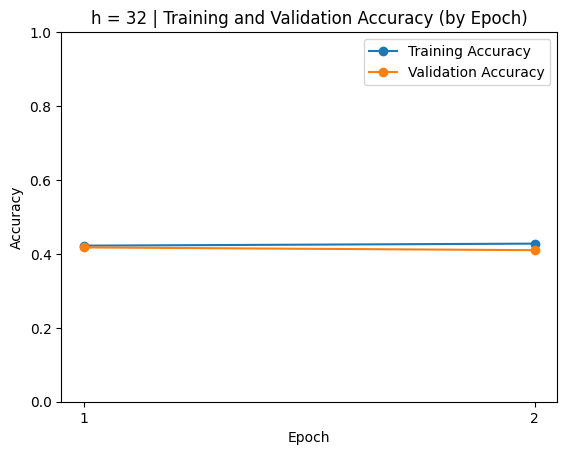

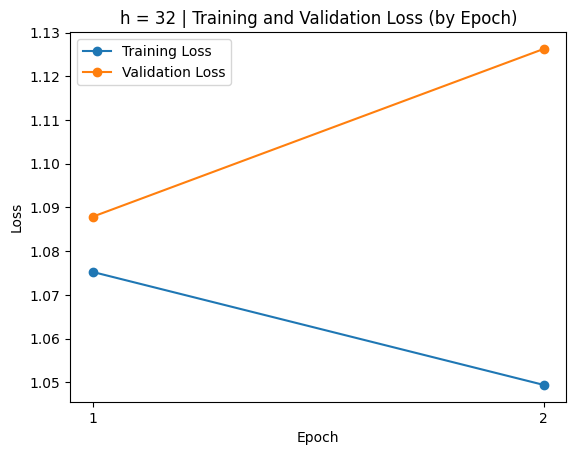

========== h = 64 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:18<00:00, 26.82it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.4135
Validation started for epoch 1


100%|██████████| 800/800 [00:01<00:00, 575.56it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4025
Training started for epoch 2


100%|██████████| 500/500 [00:18<00:00, 26.97it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.416
Validation started for epoch 2


100%|██████████| 800/800 [00:01<00:00, 561.97it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.40625
Training started for epoch 3


100%|██████████| 500/500 [00:18<00:00, 27.13it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.423625
Validation started for epoch 3


100%|██████████| 800/800 [00:01<00:00, 572.48it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.41625
Training started for epoch 4


100%|██████████| 500/500 [00:18<00:00, 27.37it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4315
Validation started for epoch 4


100%|██████████| 800/800 [00:01<00:00, 588.97it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.42125
Training started for epoch 5


100%|██████████| 500/500 [00:18<00:00, 27.60it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.43225
Validation started for epoch 5


100%|██████████| 800/800 [00:01<00:00, 589.29it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.40625
Training done to avoid overfitting!
Best validation accuracy is: 0.42125


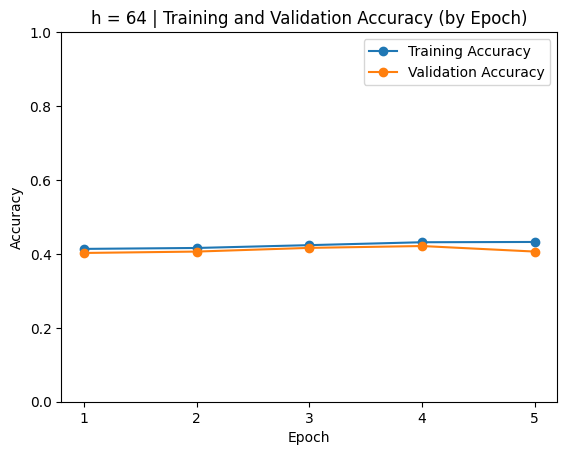

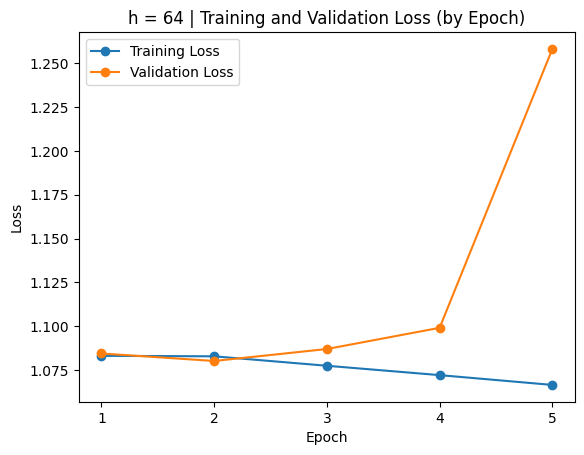

========== h = 128 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:19<00:00, 25.53it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.405875
Validation started for epoch 1


100%|██████████| 800/800 [00:01<00:00, 585.82it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4
Training started for epoch 2


100%|██████████| 500/500 [00:18<00:00, 26.38it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3945
Validation started for epoch 2


100%|██████████| 800/800 [00:01<00:00, 601.15it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4175
Training started for epoch 3


100%|██████████| 500/500 [00:18<00:00, 27.60it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.3905
Validation started for epoch 3


100%|██████████| 800/800 [00:01<00:00, 568.01it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.33125
Training started for epoch 4


100%|██████████| 500/500 [00:18<00:00, 26.86it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.402
Validation started for epoch 4


100%|██████████| 800/800 [00:01<00:00, 580.83it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.3075
Training done to avoid overfitting!
Best validation accuracy is: 0.33125


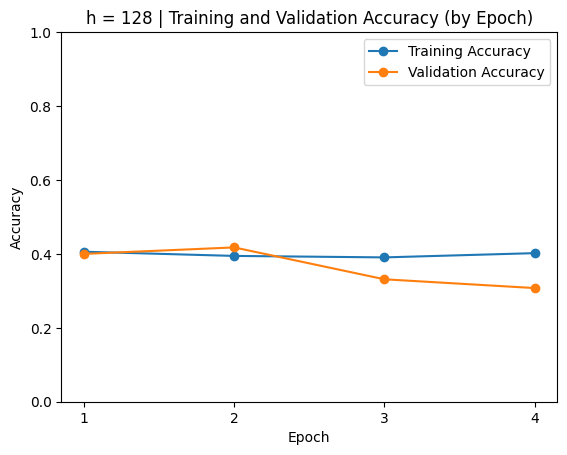

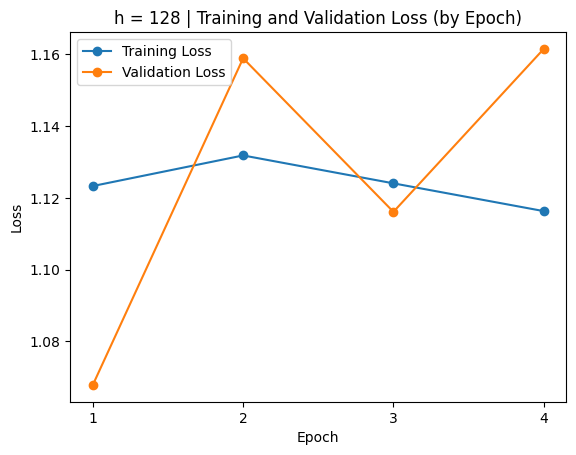

========== h = 256 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:20<00:00, 24.62it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.379
Validation started for epoch 1


100%|██████████| 800/800 [00:01<00:00, 571.11it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.41375
Training started for epoch 2


100%|██████████| 500/500 [00:19<00:00, 25.93it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.37525
Validation started for epoch 2


100%|██████████| 800/800 [00:01<00:00, 574.94it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.36125
Training started for epoch 3


100%|██████████| 500/500 [00:19<00:00, 25.50it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.372625
Validation started for epoch 3


100%|██████████| 800/800 [00:01<00:00, 553.15it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4275
Training started for epoch 4


100%|██████████| 500/500 [00:19<00:00, 25.61it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.372375
Validation started for epoch 4


100%|██████████| 800/800 [00:01<00:00, 567.12it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.4125
Training started for epoch 5


100%|██████████| 500/500 [00:19<00:00, 25.75it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.385875
Validation started for epoch 5


100%|██████████| 800/800 [00:01<00:00, 547.32it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.38875
Training done to avoid overfitting!
Best validation accuracy is: 0.4125


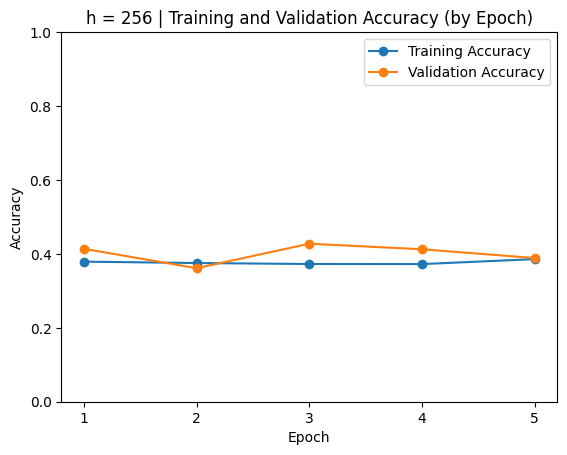

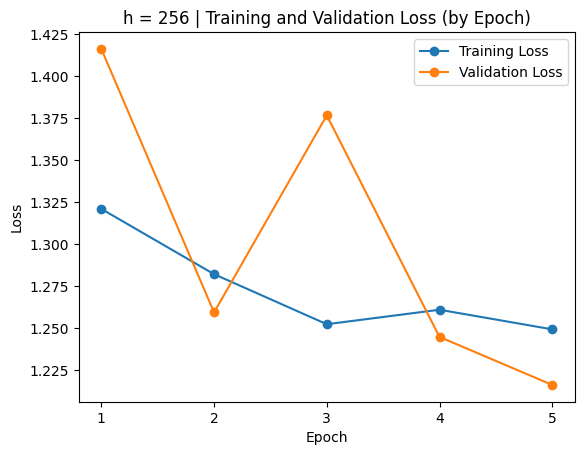

========== h = 512 ==========
Training started for epoch 1


100%|██████████| 500/500 [01:01<00:00,  8.13it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.36675
Validation started for epoch 1


100%|██████████| 800/800 [00:03<00:00, 237.59it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4025
Training started for epoch 2


100%|██████████| 500/500 [01:01<00:00,  8.11it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.363
Validation started for epoch 2


100%|██████████| 800/800 [00:04<00:00, 189.11it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.38
Training started for epoch 3


100%|██████████| 500/500 [01:00<00:00,  8.27it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.36775
Validation started for epoch 3


100%|██████████| 800/800 [00:03<00:00, 252.28it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.34625
Training done to avoid overfitting!
Best validation accuracy is: 0.38


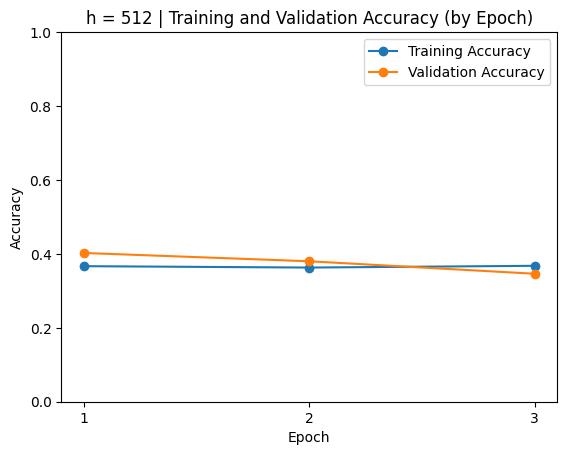

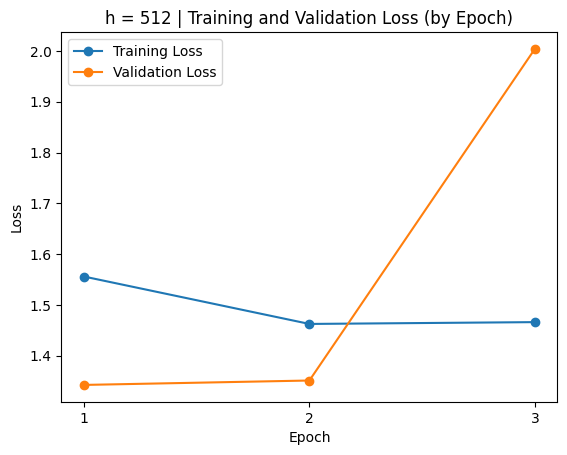

========== h = 1024 ==========
Training started for epoch 1


100%|██████████| 500/500 [01:12<00:00,  6.91it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.358875
Validation started for epoch 1


100%|██████████| 800/800 [00:04<00:00, 191.73it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.3725
Training started for epoch 2


100%|██████████| 500/500 [01:15<00:00,  6.61it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.362875
Validation started for epoch 2


100%|██████████| 800/800 [00:04<00:00, 167.70it/s]

Validation completed for epoch 2
Validation accuracy for epoch 2: 0.35875
Training done to avoid overfitting!
Best validation accuracy is: 0.3725


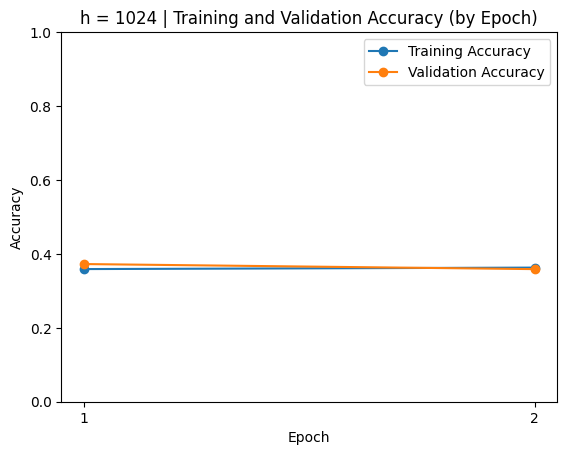

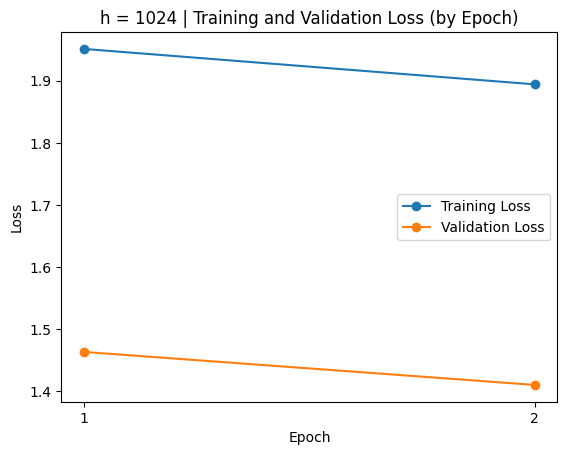

In [37]:
# Training and Validation
for hidden_dim in args.hidden_dims:
    # Create model and optimizer
    model = RNN(50, hidden_dim)
    model.to(device)  # move model to device
    (train_acc, val_acc), (train_loss, val_loss) = train_and_val(model)
    plot_acc(train_acc, val_acc, hidden_dim)
    plot_loss(train_loss, val_loss, hidden_dim)

In [38]:
# Testing
best_hidden_dim = 64
test_data = load_data(args.test_data)

In [52]:
# Stats on test data
print("Test Data Size:", len(test_data))

test_class_counts = [0] * 5
for _, y in test_data:
    test_class_counts[y] += 1
print("Test Class Counts:", test_class_counts)

Test Data Size: 800
Test Class Counts: [0, 0, 160, 320, 320]


In [40]:
model = RNN(50, best_hidden_dim)
model.to(device)  # move model to device

RNN(
  (rnn): RNN(50, 64)
  (W): Linear(in_features=64, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (loss): NLLLoss()
)

In [41]:
train_acc, test_acc = [], []
train_loss, test_loss = [], []
optimizer = optim.Adam(model.parameters(), lr=0.01)

stopping_condition = False
epoch = 0

last_train_accuracy = 0
last_testing_accuracy = 0

print("========== h = {} ==========".format(best_hidden_dim))

while not stopping_condition:
    random.shuffle(train_data)
    model.train()
    print("Training started for epoch {}".format(epoch + 1))
    train_data = train_data
    correct = total = 0
    minibatch_size = 16
    N = len(train_data)

    train_loss_total = train_loss_count = 0
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for example_index in range(minibatch_size):
            input_words, gold_label = train_data[minibatch_index * minibatch_size + example_index]
            input_words = " ".join(input_words)

            # Remove punctuation
            input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()

            # Look up word embedding dictionary
            # vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i in input_words ]
            vectors = [word_embedding.get(i.lower(), word_embedding['unk']) for i in input_words]

            # Transform the input into required shape
            vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
            output = model(vectors.to(device))

            # Get loss
            example_loss = model.compute_Loss(output.view(1,-1), torch.tensor([gold_label]).to(device))

            # Get predicted label
            predicted_label = torch.argmax(output)

            correct += int(predicted_label == gold_label)
            # print(predicted_label, gold_label)
            total += 1
            if loss is None:
                loss = example_loss
            else:
                loss += example_loss

        loss = loss / minibatch_size
        train_loss_total += loss.item()
        train_loss_count += 1
        loss.backward()
        optimizer.step()
        
    # print(train_loss_total/train_loss_count)
    print("Training completed for epoch {}".format(epoch + 1))
    print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
    trainning_accuracy = correct/total
    
    train_acc.append(trainning_accuracy)  # Append training accuracy for this epoch
    train_loss.append(train_loss_total/train_loss_count)  # Append training loss for this epoch


    model.eval()
    correct = total = 0
    test_loss_total = test_loss_count = 0
    random.shuffle(test_data)
    print("Testing started for epoch {}".format(epoch + 1))
    test_data = test_data

    with torch.no_grad():
        for input_words, gold_label in tqdm(test_data):
            input_words = " ".join(input_words)
            input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()
            vectors = [word_embedding.get(i.lower(), word_embedding['unk']) for i in input_words]

            vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
            output = model(vectors.to(device))
            predicted_label = torch.argmax(output)
            correct += int(predicted_label == gold_label)
            total += 1
            
            # Calculate the testing loss
            loss = model.compute_Loss(output.view(1, -1), torch.tensor([gold_label]).to(device))
            test_loss_total += loss.item()
            test_loss_count += 1
            # print(predicted_label, gold_label)
            
        print("Testing completed for epoch {}".format(epoch + 1))
        print("Testing accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        testing_accuracy = correct/total
        
        test_acc.append(testing_accuracy)  # Append testing accuracy for this epoch
        test_loss.append(test_loss_total/test_loss_count)  # Append testing loss for this epoch

    if testing_accuracy < last_testing_accuracy and trainning_accuracy > last_train_accuracy:
        stopping_condition=True
        print("Training done to avoid overfitting!")
        print("Best testing accuracy is:", last_testing_accuracy)
    else:
        last_testing_accuracy = testing_accuracy
        last_train_accuracy = trainning_accuracy

    epoch += 1

========== h = 64 ==========
Training started for epoch 1


100%|██████████| 500/500 [00:20<00:00, 24.31it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.409625
Testing started for epoch 1


100%|██████████| 800/800 [00:01<00:00, 659.37it/s]


Testing completed for epoch 1
Testing accuracy for epoch 1: 0.0
Training started for epoch 2


100%|██████████| 500/500 [00:18<00:00, 26.69it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.42525
Testing started for epoch 2


100%|██████████| 800/800 [00:01<00:00, 733.23it/s]


Testing completed for epoch 2
Testing accuracy for epoch 2: 0.0
Training started for epoch 3


100%|██████████| 500/500 [00:17<00:00, 28.37it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.420875
Testing started for epoch 3


100%|██████████| 800/800 [00:01<00:00, 741.78it/s]


Testing completed for epoch 3
Testing accuracy for epoch 3: 0.0
Training started for epoch 4


100%|██████████| 500/500 [00:17<00:00, 28.58it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4255
Testing started for epoch 4


100%|██████████| 800/800 [00:01<00:00, 748.64it/s]


Testing completed for epoch 4
Testing accuracy for epoch 4: 0.0
Training started for epoch 5


100%|██████████| 500/500 [00:17<00:00, 28.13it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.426125
Testing started for epoch 5


100%|██████████| 800/800 [00:01<00:00, 729.54it/s]


Testing completed for epoch 5
Testing accuracy for epoch 5: 0.00625
Training started for epoch 6


100%|██████████| 500/500 [00:17<00:00, 28.12it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.4265
Testing started for epoch 6


100%|██████████| 800/800 [00:01<00:00, 638.31it/s]

Testing completed for epoch 6
Testing accuracy for epoch 6: 0.00375
Training done to avoid overfitting!
Best testing accuracy is: 0.00625


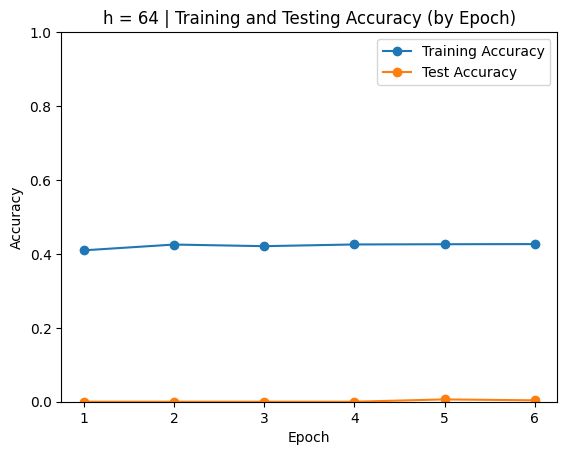

In [42]:
epochs = np.arange(1, len(train_acc) + 1)

# Plot training accuracy and validation accuracy on the same graph
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='o', linestyle='-')

# Set axis labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Display the plot
plt.xticks(np.arange(1, len(train_acc) + 1, step=1))
plt.ylim(0, 1)
plt.title('h = {} | Training and Testing Accuracy (by Epoch)'.format(best_hidden_dim))
plt.show()

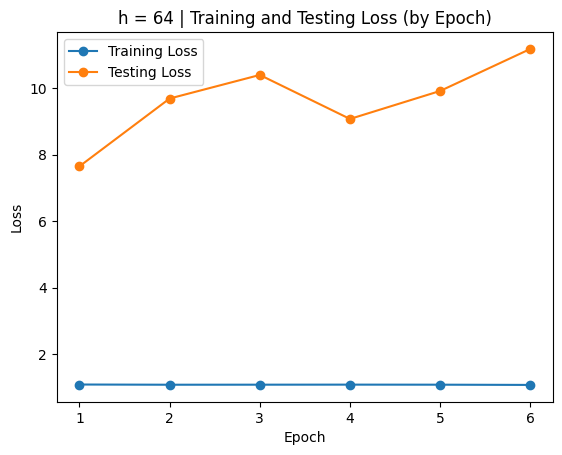

In [43]:
# Create an array for the number of epochs, e.g., [1, 2, 3, ...]
epochs = np.arange(1, len(train_loss) + 1)

# Plot training accuracy and validation accuracy on the same graph
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, test_loss, label='Testing Loss', marker='o', linestyle='-')

# Set axis labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

# Display the plot
plt.xticks(np.arange(1, len(train_loss) + 1, step=1))
plt.title('h = {} | Training and Testing Loss (by Epoch)'.format(best_hidden_dim))
plt.show()